In [2]:
import tensorflow
tensorflow.__version__

'2.3.0'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import tensorflow as tf
import os
os.chdir('drive/My Drive/Colab Notebooks')

In [13]:
from zipfile import ZipFile
zip_ref = ZipFile('Aligned Face Dataset from Pinterest.zip')

In [7]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
!unzip 'Aligned Face Dataset from Pinterest.zip' -d Dataset

Clearing the output since it was a huge and couldn''t collapse using %%capture

In [5]:
import numpy as np

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('Dataset/PINS')

In [6]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

zendaya


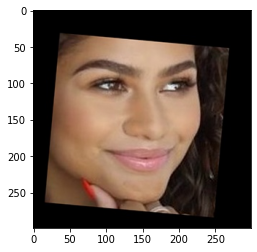

In [7]:
import matplotlib.pyplot as plt
n=10769
img = load_image(metadata[n].image_path())
label=(metadata[n].name)
print(''+label[5:])
plt.imshow(img)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [9]:
model = vgg_face()

In [10]:
model.load_weights('vgg_face_weights.h5')

In [11]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [12]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))

for i,m in enumerate(metadata):
  try:
    img = load_image(str (m))
#img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)

    img = cv2.resize(img, dsize = (224,224))
#print(img.shape)
#      print(img.shape)
# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
  except:
    embeddings[i] = np.zeros(2622)

In [13]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

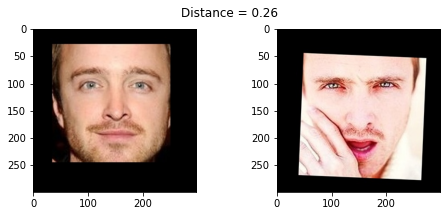

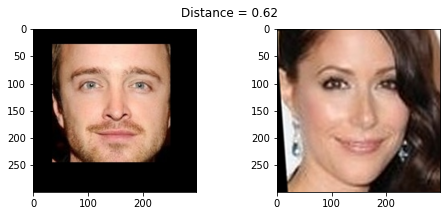

In [14]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

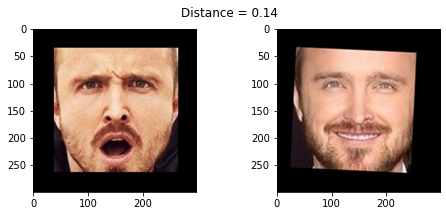

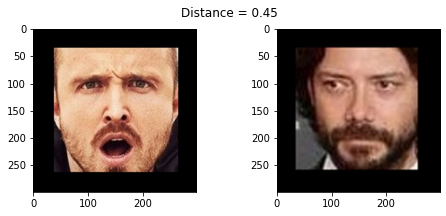

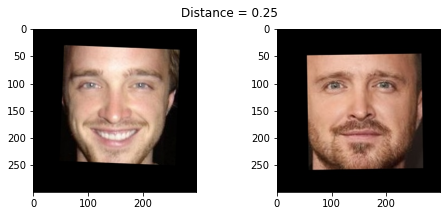

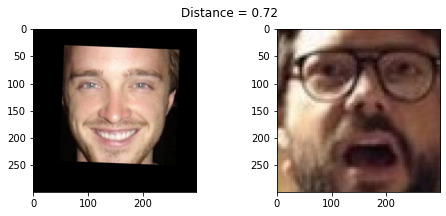

In [32]:
show_pair(30, 31)
show_pair(30, 100)
show_pair(70, 72)
show_pair(70, 115)

In [78]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
#train labels
y_train = targets[train_idx]
#test labels
y_test = targets[test_idx]

In [79]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

(9573, 2622)
(1197, 2622)
(9573,)
(1197,)


In [80]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [81]:
# Standarize features
from sklearn.preprocessing import StandardScaler
std_sc = StandardScaler()
X_train = std_sc.fit_transform(X_train)
X_test = std_sc.transform(X_test)

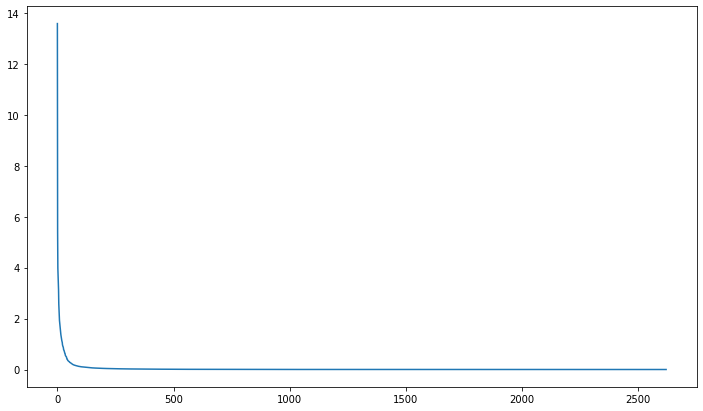

In [82]:
from sklearn.decomposition import PCA
cov_matrix = np.cov(X_train.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
tot = sum(eigenvalues)
var_exp = [( i /tot ) * 100 for i in sorted(eigenvalues, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(12 , 7))
plt.plot(var_exp)

In [83]:
pca = PCA(n_components = 128,whiten = True)
pca.fit(X_train)
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)
display(X_train_reduced.shape, X_test_reduced.shape)

(9573, 128)

(1197, 128)

In [84]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
SVC_Algo = SVC(C = 1, gamma = 'auto', kernel = 'rbf')
#C=1, gamma=0.001, kernel = 'rbf',class_weight='balanced'

#Train the model using the training sets
SVC_Algo.fit(X_train_reduced, y_train)

#Predict the response for test dataset
y_pred = SVC_Algo.predict(X_test_reduced)

print('Training Score: ', SVC_Algo.score(X_train_reduced, y_train).round(3))
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Training Score:  0.997
Accuracy: 0.965


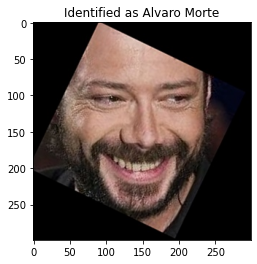

In [87]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = SVC_Algo.predict([X_test_reduced[example_idx]])
example_identity = le.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity[5:]}');

In [88]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

**Conclusion**

- Used the pretrained model Vgg_face to recognize similar faces.
- Created embeded vector for each face and used distance metric to identify distance between / similarity between 2 images
- Used PCA for dimensionality reduction and SVM classifier to map each image to it's right person and predit for some examples.
- Achieved accuracy of 96.5% 